In [1]:
from matplotlib import pyplot as plt
from parselog import *
import itertools
import multiprocessing
import numpy as np
import os
import pickle
import sys

In [2]:
PREFETCHERS = [
    "all_in_cap",
    "cap_spatial",
    "cap_ptr",
    "cap_spatial_ptr",
    "cheri_stride",
    "stride",
    "stride_adaptive",
]

In [3]:
LOCATIONS = ["l1", "l1ll"]

In [4]:
BENCHMARKS = [
    "adpcm_decode",
    "adpcm_encode",
    "aes",
    "basicmath",
    "blowfish",
    "crc",
    "dijkstra",
    "fft",
    "picojpeg",
    "qsort",
    "rc4",
]

In [5]:
RUN = "capptr4"

In [6]:
def statL1AccessFrequency(lp):
    return lp.totals[CRqCreationLine]["demand"]/lp.totals[RVFILine]["total"]

def statL1DemandHitRate(lp):
    return lp.totals[CRqCreationLine]["demandHit"]/lp.totals[CRqCreationLine]["demand"]

def statL1DemandMissRate(lp):
    return lp.totals[CRqCreationLine]["demandMiss"]/lp.totals[CRqCreationLine]["demand"]

def statL1PrefetchFrequency(lp):
    return lp.totals[CRqCreationLine]["prefetch"]/lp.totals[RVFILine]["total"]

def statL1PrefetchCreation(lp):
    return lp.totals[CRqCreationLine]["prefetch"]

def statL1PrefetchHitRate(lp):
    if lp.totals[CRqCreationLine]["prefetch"]:
        return lp.totals[CRqCreationLine]["prefetchHit"]/lp.totals[CRqCreationLine]["prefetch"]
    else:
        return 0
    
def statL1PrefetchMissRate(lp):
    if lp.totals[CRqCreationLine]["prefetch"]:
        return lp.totals[CRqCreationLine]["prefetchMiss"]/lp.totals[CRqCreationLine]["prefetch"]
    else:
        return 0
    
def statL1PrefetchAccuracy(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return (lp.totals[CRqCreationLine]["prefetchMiss"]-lp.totals[CRqCreationLine]["uselessPrefetch"])/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0
    
def statL1LatePrefetchCreationFrequency(lp):
    denom = lp.totals[CRqCreationLine]["prefetchHit"] + lp.totals[CRqCreationLine]["prefetchOwned"]
    if denom:
        return lp.totals[CRqCreationLine]["latePrefetchCreation"]/denom
    else:
        return 0
    
def statL1LatePrefetchIssueFrequency(lp):
    denom = lp.totals[CRqCreationLine]["prefetchMiss"]
    if denom:
        return lp.totals[CRqCreationLine]["latePrefetchIssue"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0
    
def statILP(lp):
    for ll in reversed(lp.logLines):
        if isinstance(ll, RVFILine):
            return ll.rvfi/ll.timestamp
        
def statL1LineContainsPointersFrequency(lp):
    return sum(x > 0 for x in lp.dists[CRqHitLine]["missNCap"]) / lp.totals[CRqMissLine]["total"]

def statL1AllInCapTriggerFrequency(lp):
    return sum(x <= 256 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapSpatialFrequency(lp):
    return sum(x <= 32768 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapPtrFrequency(lp):
    return sum(x <= 2097152 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapSpatialPtrFrequency(lp):
    return sum(x <= 1048576 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1PrefetchDisruption(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return lp.totals[CRqCreationLine]["prefetchDisruption"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0

def statL1AccessCapSize16HasPointers(lp):
    return sum(x <= 16 for x in lp.dists[CRqCreationLine]["demandHasPtrsCapSize"]) / sum(x > 0 for x in lp.dists[CRqHitLine]["demandNCap"])

def statZeroNonStackCacheAlignedOffsetsAccessed(lp):
    if CapPtrDataAddTTableEntryLine in lp.dists:
        return sum(x == 0 for x in lp.dists[CapPtrDataAddTTableEntryLine]["numNonStackCacheAlignedOffsetsAccessed"]) / lp.totals[CapPtrDataAddTTableEntryLine]["total"]
    else:
        return 0
    
def statOneNonStackCacheAlignedOffsetsAccessed(lp):
    if CapPtrDataAddTTableEntryLine in lp.dists:
        return sum(x == 1 for x in lp.dists[CapPtrDataAddTTableEntryLine]["numNonStackCacheAlignedOffsetsAccessed"]) / lp.totals[CapPtrDataAddTTableEntryLine]["total"]
    else:
        return 0
    
def statL1UselessPrefetchDisruption(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return lp.totals[CRqCreationLine]["uselessPrefetchDisruption"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0

statFuncs = {
    "Speedup"                                       : (lambda x: None),                   
    "ILP"                                           : statILP,                            
    "L1 Access Frequency"                           : statL1AccessFrequency,              
    "L1 Demand Hit Rate"                            : statL1DemandHitRate,                
    "L1 Demand Miss Rate"                           : statL1DemandMissRate,               
    "L1 Prefetch Frequency"                         : statL1PrefetchFrequency,            
    "L1 Prefetch Creation"                          : statL1PrefetchCreation,             
    "L1 Prefetch Hit Rate"                          : statL1PrefetchHitRate,              
    "L1 Prefetch Miss Rate"                         : statL1PrefetchMissRate,             
    "L1 Prefetcher Accuracy"                        : statL1PrefetchAccuracy,             
    "L1 Prefetcher Coverage"                        : (lambda x: None),                   
    "L1 Late Prefetch Creation Frequency"           : statL1LatePrefetchCreationFrequency,
    "L1 Late Prefetch Issue Frequency"              : statL1LatePrefetchIssueFrequency,   
    "L1 New Line Contains Pointers Frequency"       : statL1LineContainsPointersFrequency,
    "L1 AllInCap Trigger Frequency (256)"           : statL1AllInCapTriggerFrequency,     
    "L1 CapSpatial Trigger Frequency (32768)"        : statL1CapSpatialFrequency,          
    "L1 CapPtr Trigger Frequency (2097152)"         : statL1CapPtrFrequency,              
    "L1 CapSpatialPtr Trigger Frequency (1048576)"  : statL1CapSpatialPtrFrequency,       
    "L1 Prefetch Disruption Frequency"              : statL1PrefetchDisruption,    
    "L1 Uselss Prefetch Disruption Frequency"       : statL1UselessPrefetchDisruption,    
    "L1 Access Cap Size <=16 Has Pointers"          : statL1AccessCapSize16HasPointers,
    "CapPtr Training Table Never Accessed"          : statZeroNonStackCacheAlignedOffsetsAccessed,
    "CapPtr Training Table Accessed Once"           : statOneNonStackCacheAlignedOffsetsAccessed,
}

noPrefetcherRequiredForStat = [
    "L1 Access Frequency",
    "L1 New Line Contains Pointers Frequency",
    "L1 AllInCap Trigger Frequency (256)",
    "L1 CapSpatial Trigger Frequency (32768)",
    "L1 CapPtr Trigger Frequency (2097152)",
    "L1 CapSpatialPtr Trigger Frequency (1048576)",
    "L1 Access Cap Size <=16 Has Pointers",
]

noBaselineRequiredForStat = [
    "Speedup",
    "L1 Prefetch Frequency",
    "L1 Prefetch Creation",
    "L1 Prefetch Hit Rate",
    "L1 Prefetch Miss Rate",
    "L1 Prefetcher Accuracy",
    "L1 Prefetcher Coverage",
    "L1 Late Prefetch Creation Frequency",
    "L1 Late Prefetch Issue Frequency",
    "CapPtr Training Table Never Accessed",
    "CapPtr Training Table Accessed Once",
]

In [7]:

def loadPrefetcherData(run, prefetcher, location, benchmark):
    stats = {}
    logPath = f"results/{run}-{prefetcher}-{location}/{benchmark}/sim_stdout.gz"
    lp = None
    if os.path.isfile(logPath):
        sys.stdout.write(f"Loading {run}-{prefetcher}-{location}/{benchmark}...\n")
        sys.stdout.flush()
        oldStdout = sys.stdout
        with open(os.devnull, "w") as sys.stdout:
            lp = LogParser(
                log=logPath, 
                lineTypesToPrune=[None, NonRVFILine],
                lineTypesToError=[TimestampedLine],
                RootLogLine=TimestampedLine,
                startWhen=(lambda ll: isinstance(ll, RVFILine) and ll.rvfi >= 10000),
            );
        sys.stdout = oldStdout
        sys.stdout.write(f"... loaded {run}-{prefetcher}-{location}/{benchmark}\n")
        sys.stdout.flush()
    for statName, statFunc in statFuncs.items():
        stats[statName] = statFunc(lp) if lp else 0
    return run, prefetcher, location, benchmark, stats

def mute():
    sys.stdout = open(os.devnull, 'w') 

def loadPrefetcherDataWrapper(args):
    return loadPrefetcherData(*args)

PREFETCHERS = ["cap_ptr"]
LOCATIONS = ["l1"]
RUN = "capptr6"

globalStats = {}
if os.path.isfile("results/globalStats.pickle"):
    print("Loading from pickle...")
    with open("results/globalStats.pickle", "rb") as fp:
        globalStats = pickle.load(fp)
    print("... finished loading from pickle")
else:
    globalStats = {}
    pool = None
    with multiprocessing.Pool(processes=48) as pool:

        none_tuples = [(RUN, "none", "none", benchmark) for benchmark in BENCHMARKS]
        some_tuples = itertools.product([RUN], PREFETCHERS, LOCATIONS, BENCHMARKS)
        all_tuples = [*none_tuples, *some_tuples]

        results = pool.map(loadPrefetcherDataWrapper, all_tuples)

        for run, prefetcher, location, benchmark, stats in results:
            for statName, statValue in stats.items():
                if not run in globalStats:
                    globalStats[run] = {}
                if not statName in globalStats[run]:
                    globalStats[run][statName] = {}
                if not prefetcher in globalStats[run][statName]:
                    globalStats[run][statName][prefetcher] = {}
                if not location in globalStats[run][statName][prefetcher]:
                    globalStats[run][statName][prefetcher][location] = []            
                globalStats[run][statName][prefetcher][location].append(statValue)

        for run, prefetcher, location, benchmark in all_tuples:
            for i in range(len(BENCHMARKS)):
                globalStats[run]["Speedup"][prefetcher][location][i] = (
                    globalStats[run]["ILP"][prefetcher][location][i] / 
                    globalStats[run]["ILP"]["none"]["none"][i]
                ) - 1
                globalStats[run]["L1 Prefetcher Coverage"][prefetcher][location][i] = 1 - (
                    globalStats[run]["L1 Demand Miss Rate"][prefetcher][location][i] /
                    globalStats[run]["L1 Demand Miss Rate"]["none"]["none"][i]
                )

    with open("results/globalStats.pickle", "wb") as fp:
        pickle.dump(globalStats, fp)


Loading capptr6-none-none/adpcm_decode...
Loading capptr6-none-none/adpcm_encode...
Loading capptr6-none-none/aes...
Loading capptr6-none-none/basicmath...
Loading capptr6-none-none/blowfish...
Loading capptr6-none-none/crc...
Loading capptr6-none-none/dijkstra...
Loading capptr6-none-none/fft...
Loading capptr6-none-none/qsort...
Loading capptr6-none-none/rc4...
Loading capptr6-none-none/picojpeg...
Loading capptr6-cap_ptr-l1/adpcm_encode...
Loading capptr6-cap_ptr-l1/aes...
Loading capptr6-cap_ptr-l1/basicmath...
Loading capptr6-cap_ptr-l1/adpcm_decode...
Loading capptr6-cap_ptr-l1/fft...
Loading capptr6-cap_ptr-l1/crc...
Loading capptr6-cap_ptr-l1/blowfish...
Loading capptr6-cap_ptr-l1/dijkstra...
Loading capptr6-cap_ptr-l1/picojpeg...
Loading capptr6-cap_ptr-l1/qsort...
Loading capptr6-cap_ptr-l1/rc4...
... loaded capptr6-none-none/crc
... loaded capptr6-cap_ptr-l1/crc
... loaded capptr6-none-none/aes
... loaded capptr6-cap_ptr-l1/aes
... loaded capptr6-none-none/rc4
... loaded cap

/tmp/ipykernel_1715093/4140305699.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(11,5))


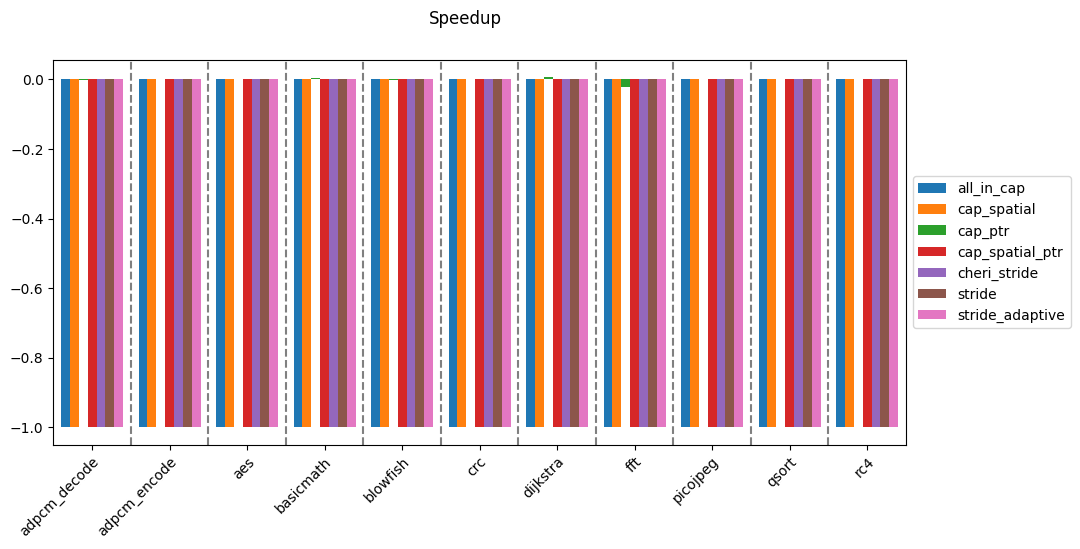

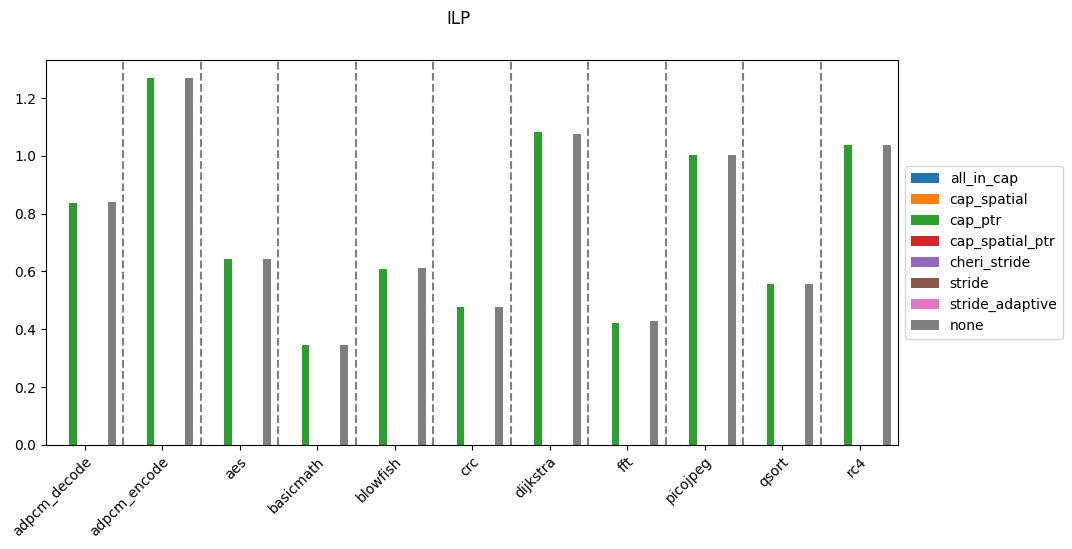

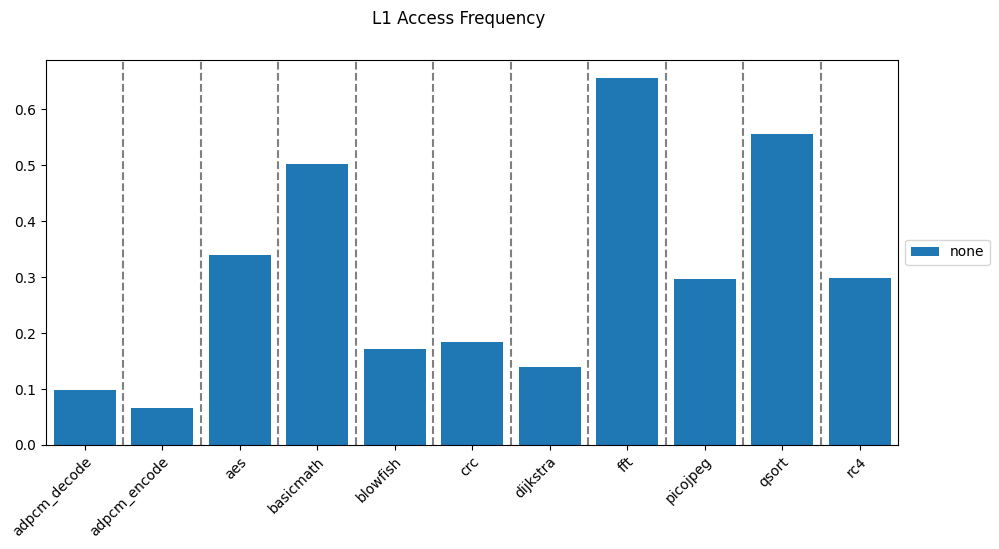

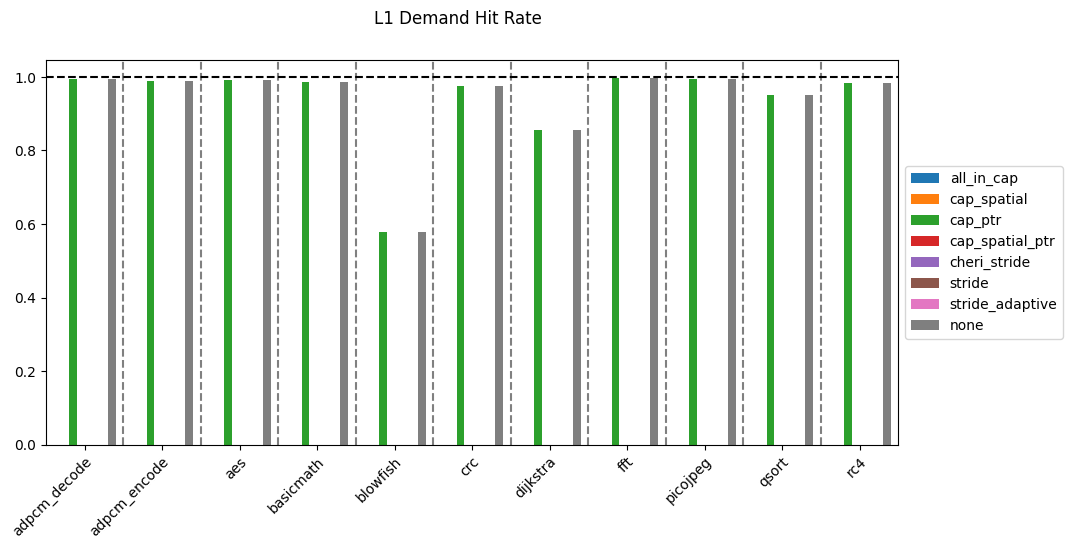

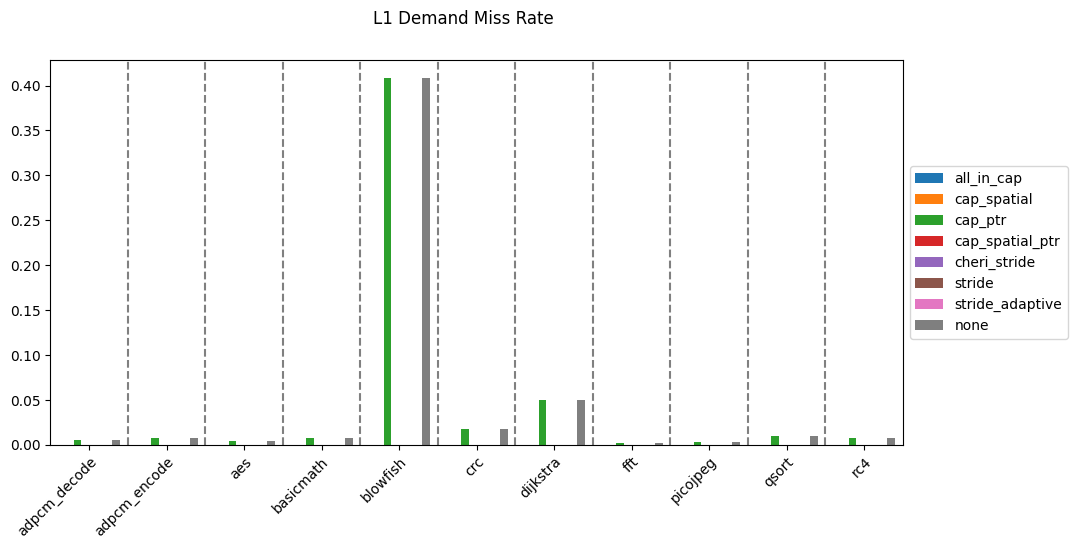

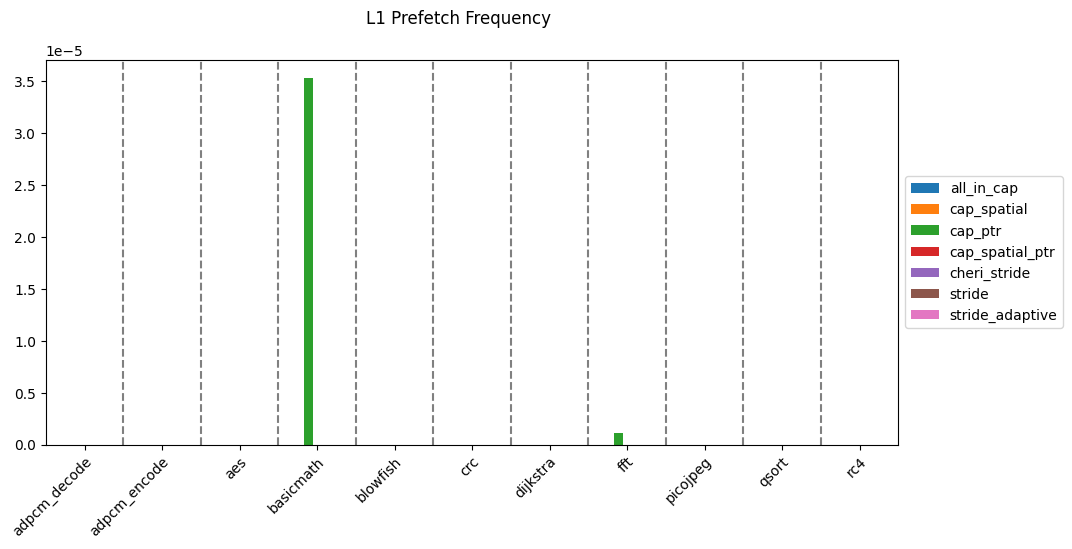

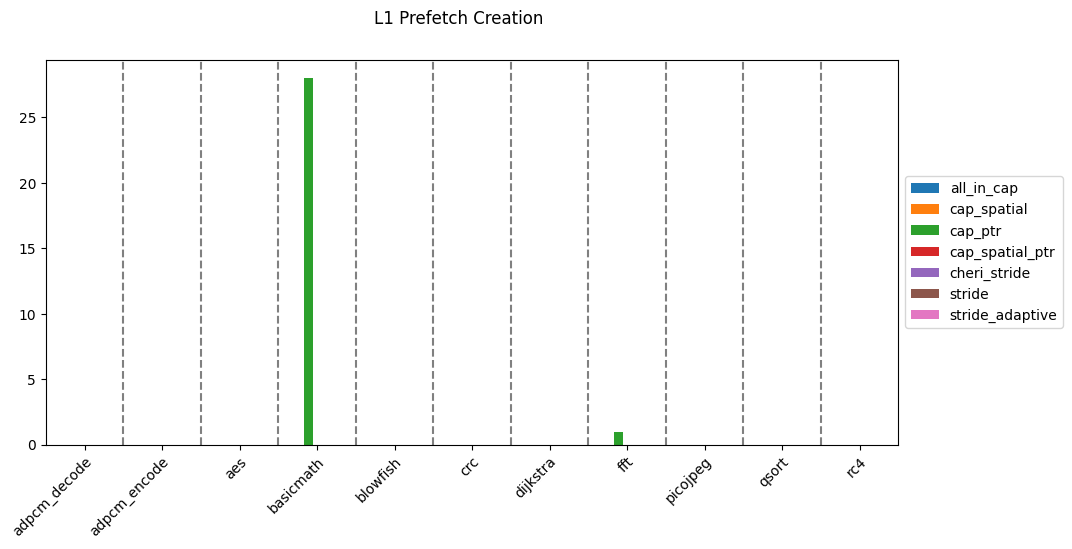

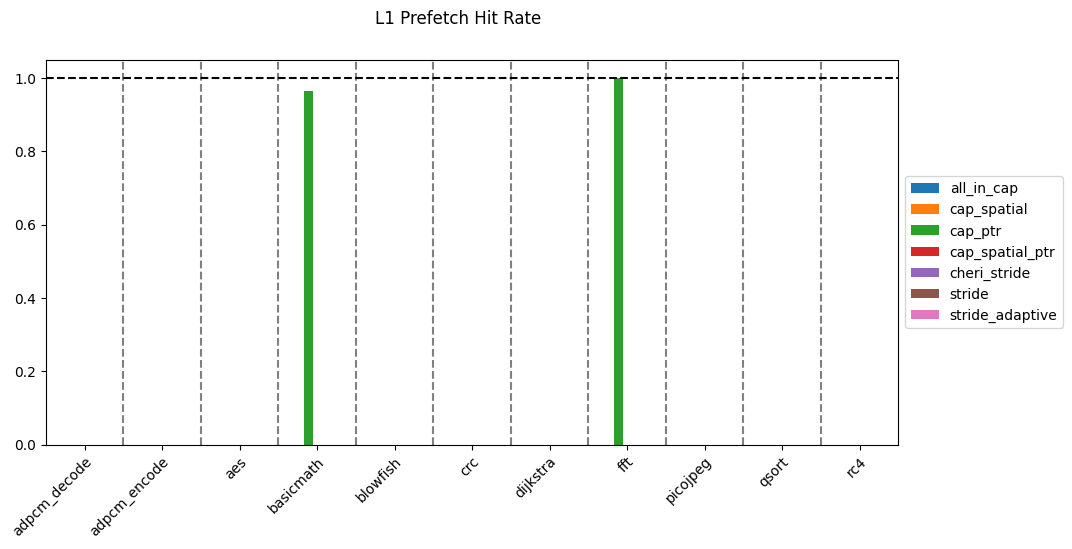

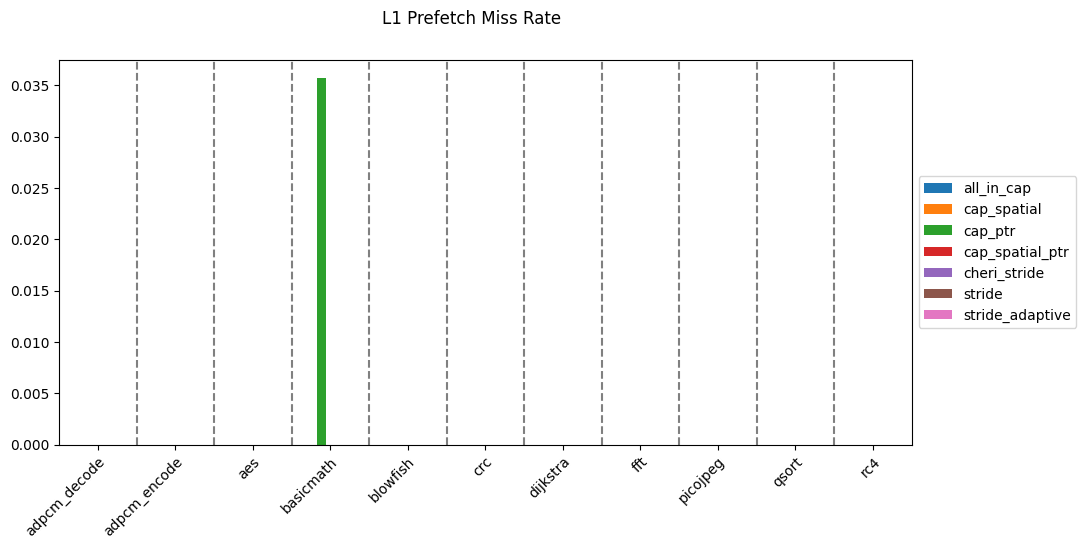

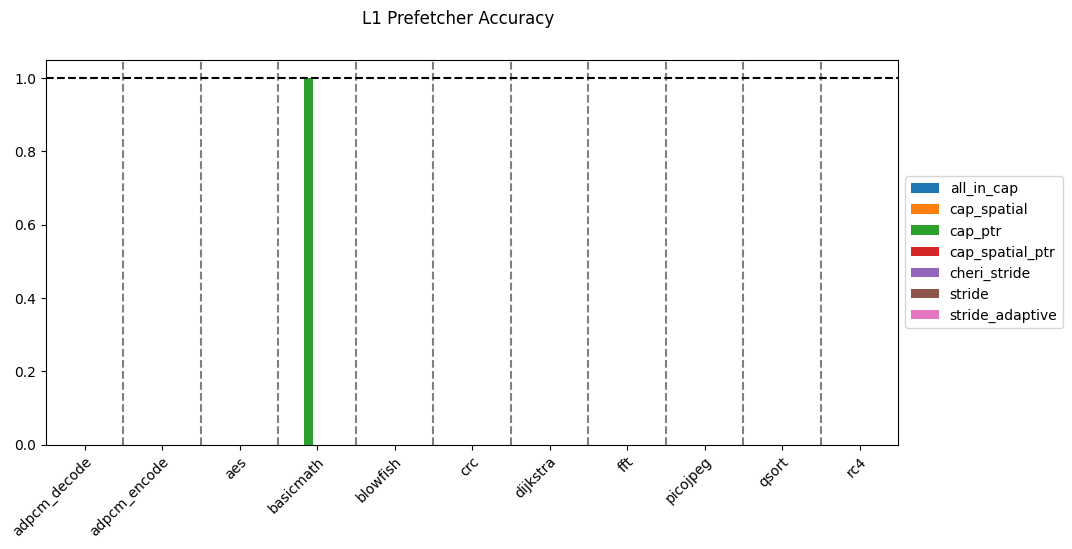

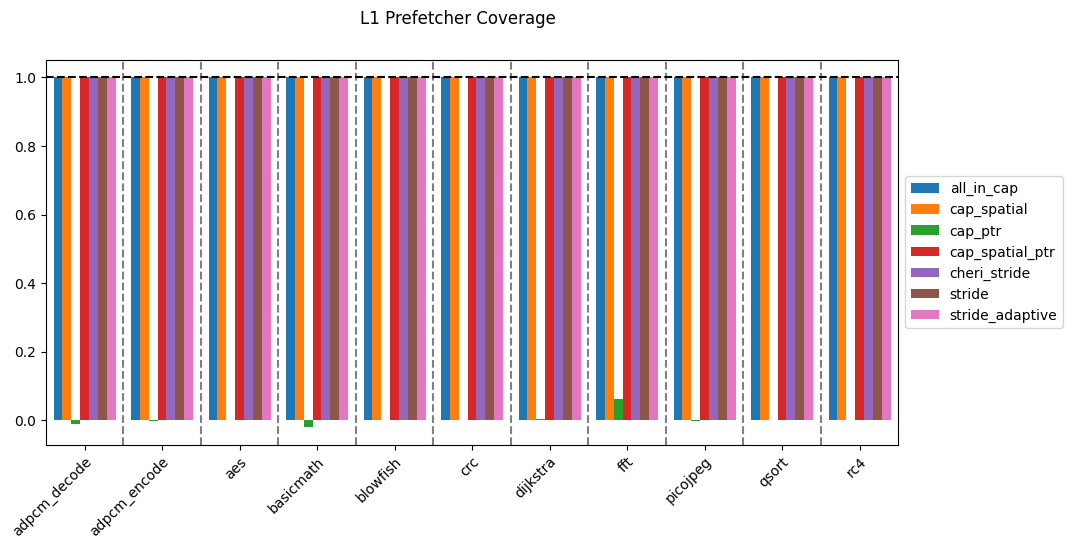

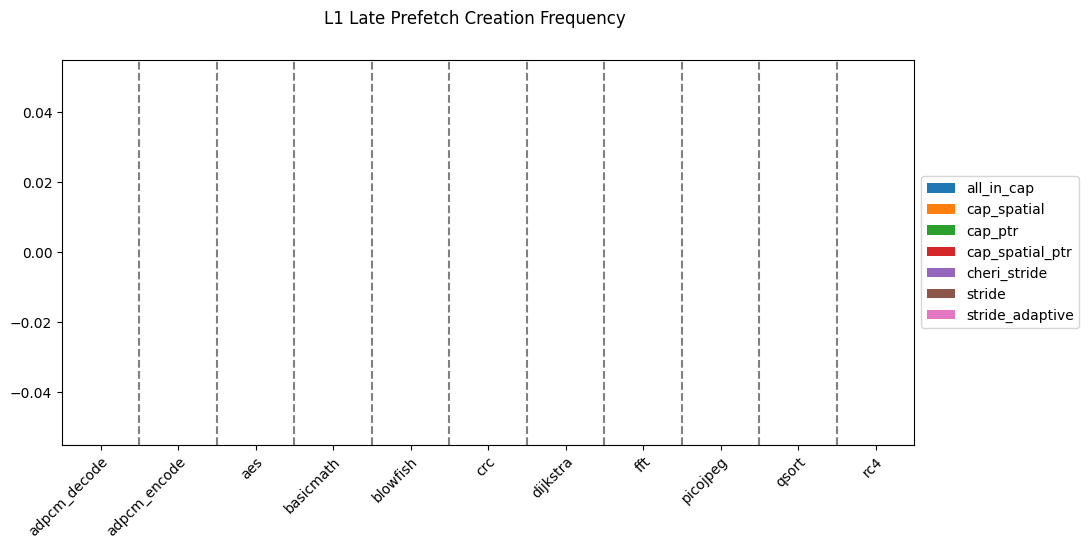

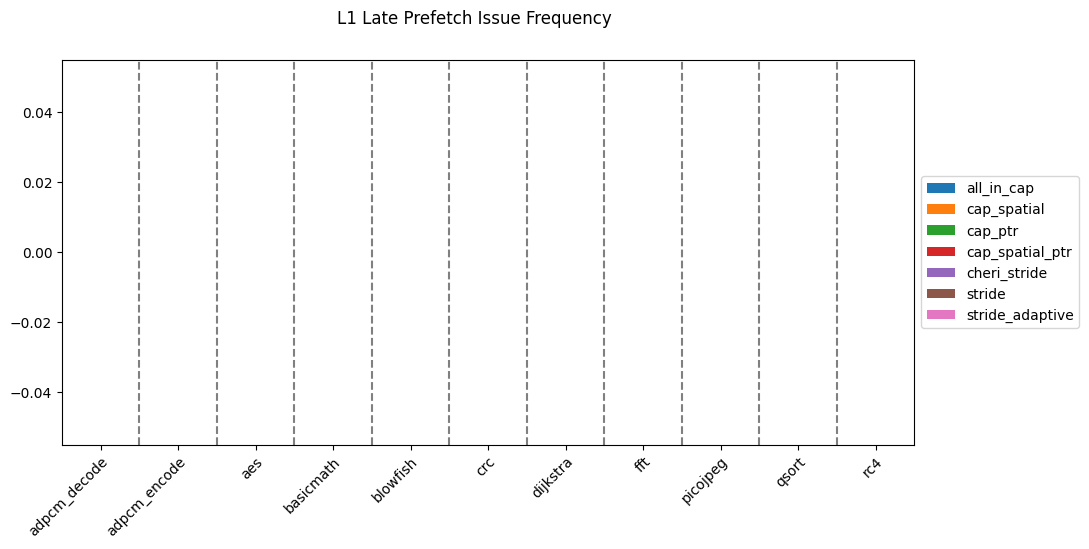

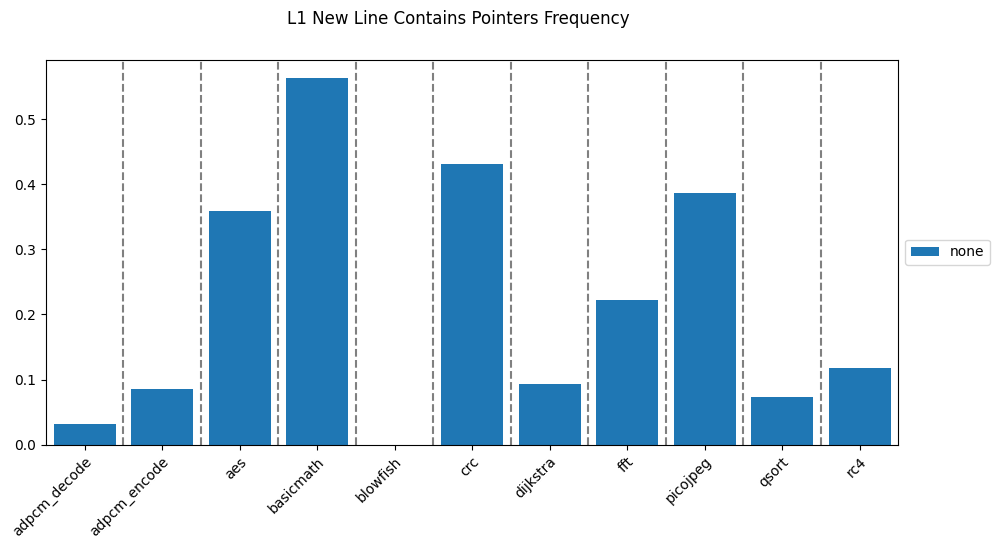

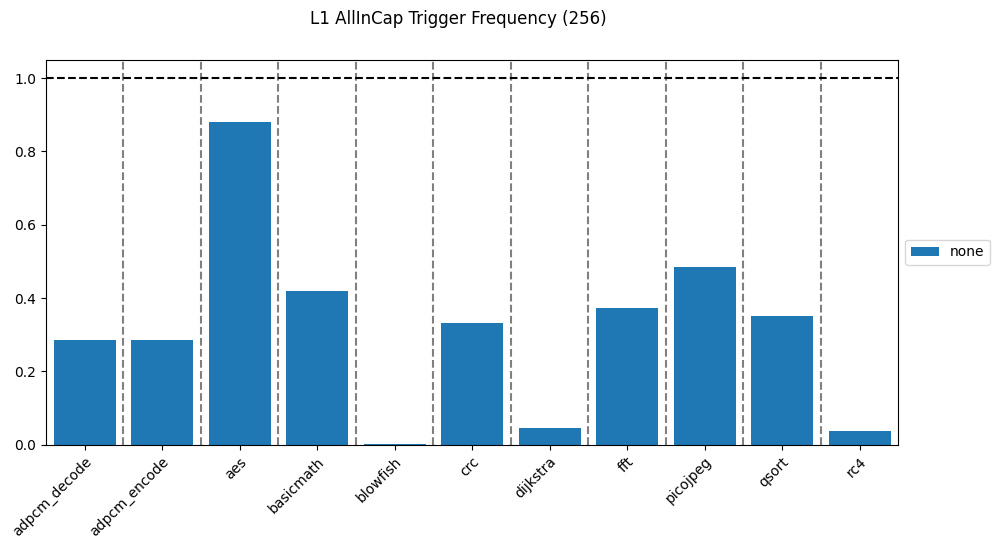

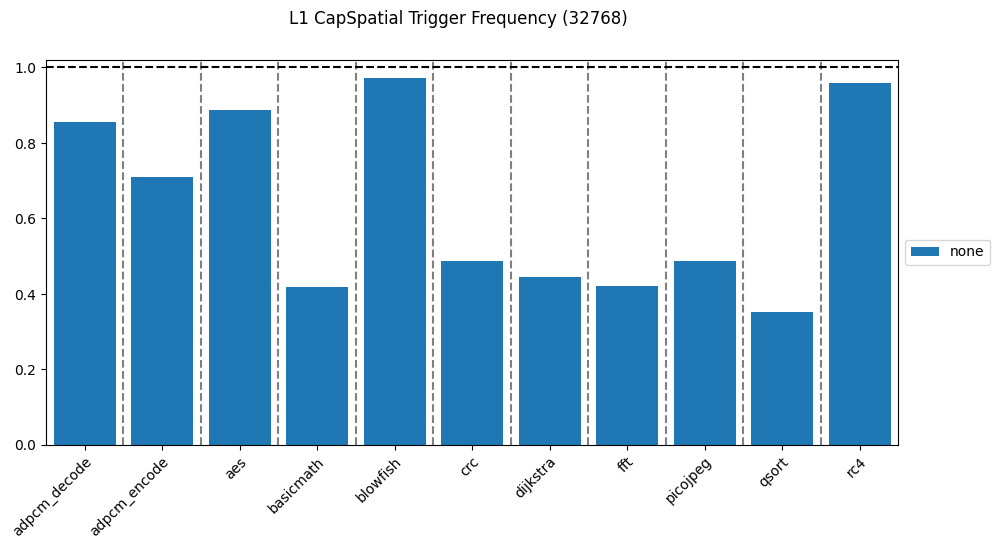

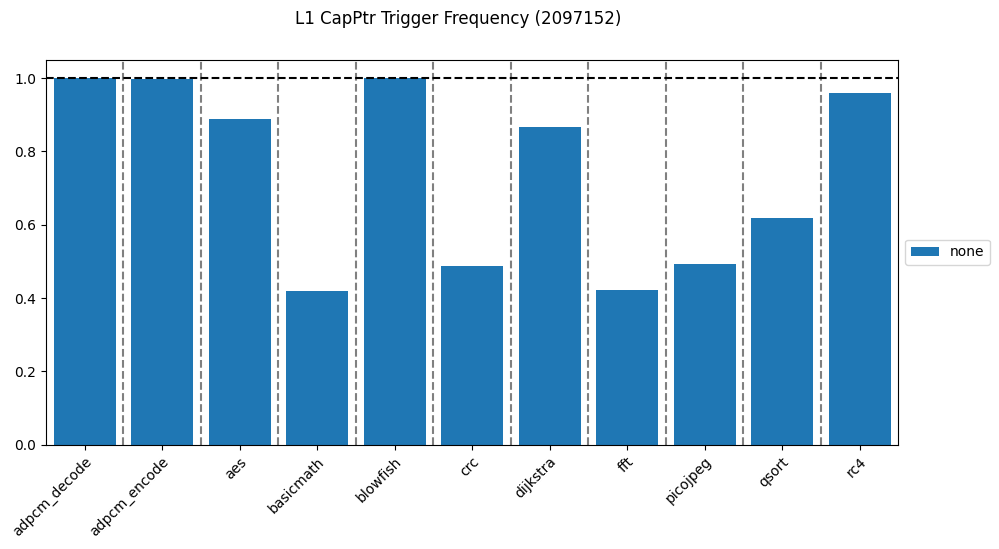

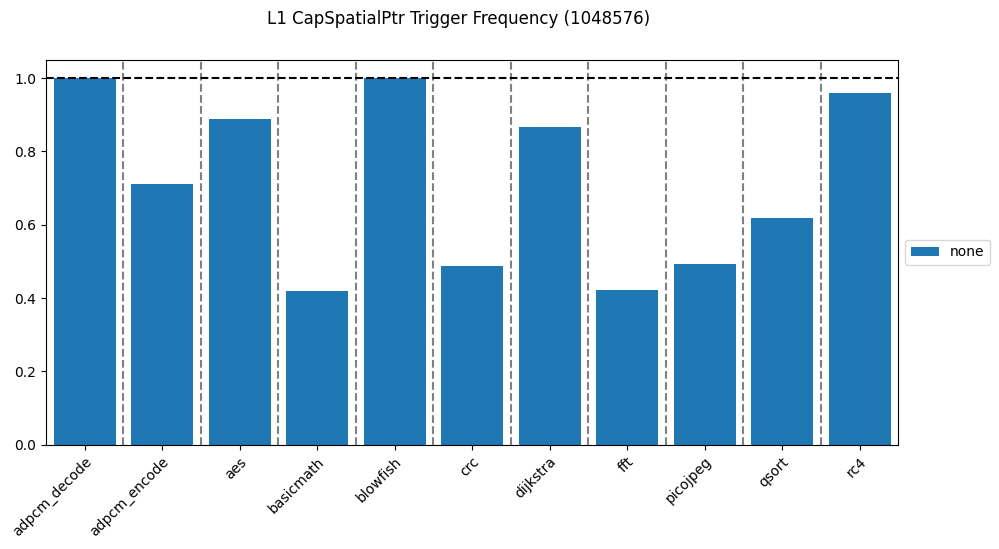

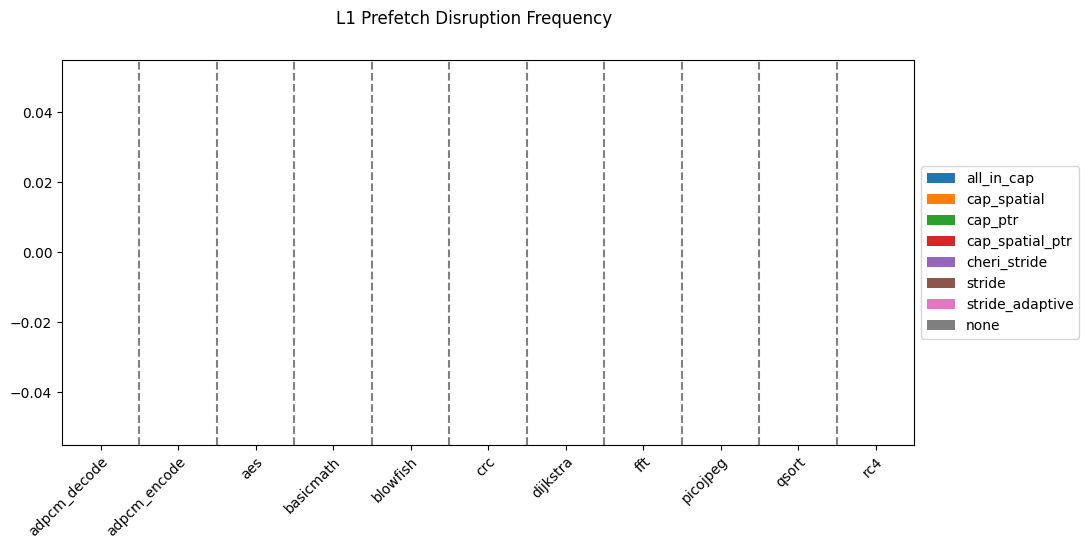

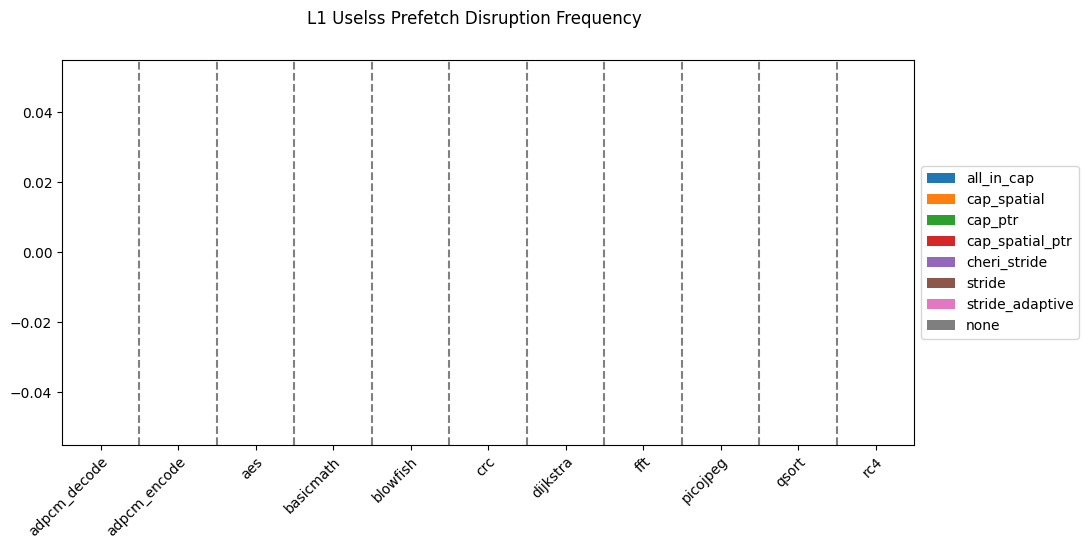

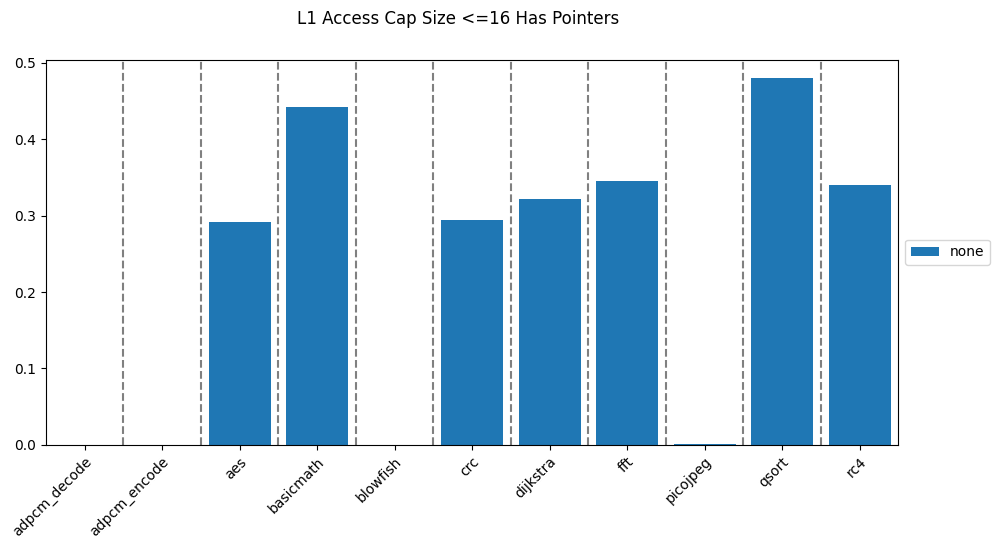

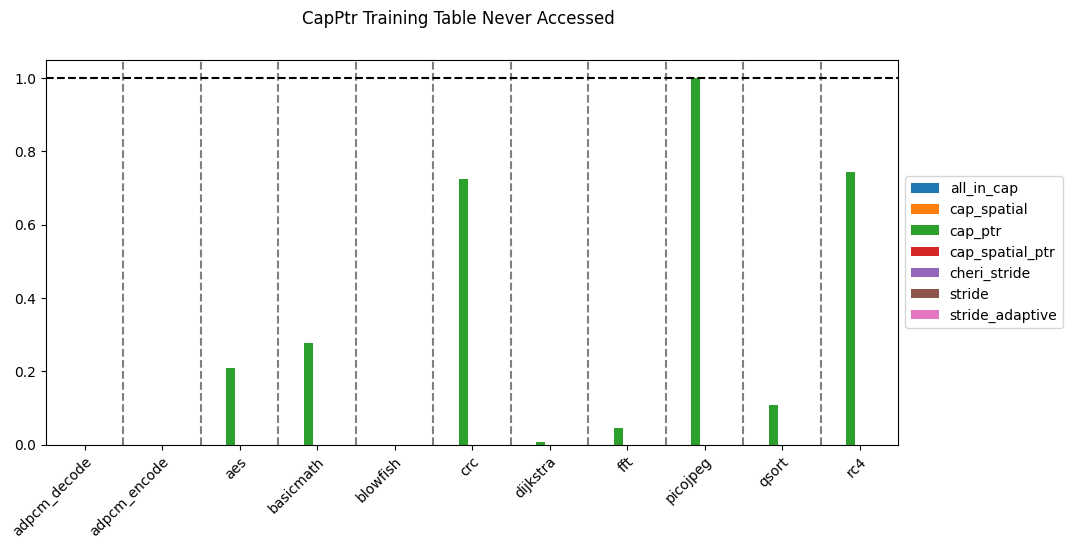

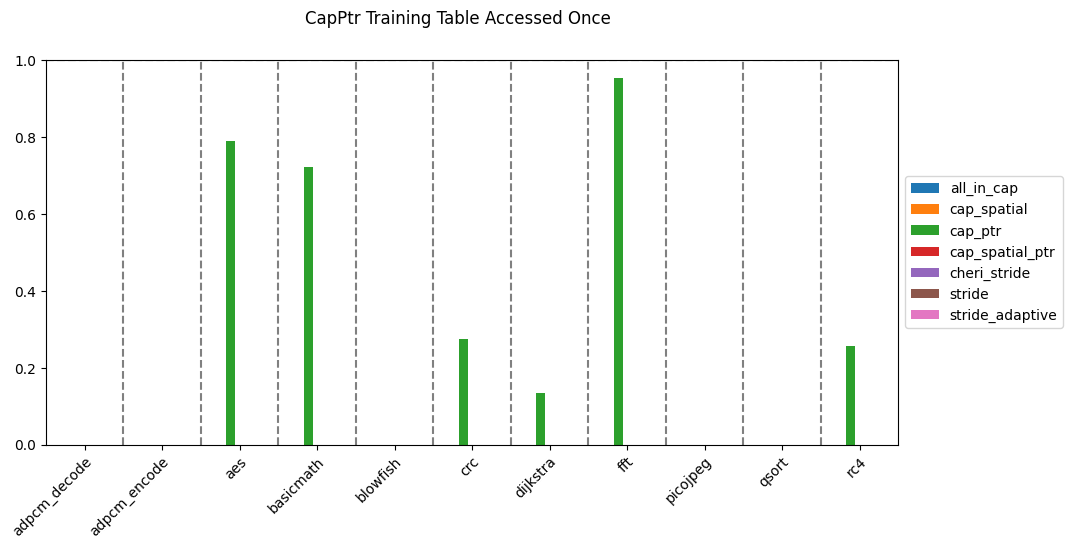

In [8]:
def groupedBarChart(
    data: dict[str, list],
    cats: list[str],
    figax=None
):
    fig, ax = figax if figax is not None else plt.subplots()
    nCats = len(cats)
    nGroups = len(data)
    assert(all(len(group) == nCats for group in data.values()))
     
    leqOne = True
    drawOne = False
    makeLog = False
    barWidth = 0.8 / nGroups
    xs = np.arange(nCats)
    for i, (groupName, groupData) in enumerate(data.items()):
        leqOne  = leqOne and all(d <= 1 for d in groupData)
        drawOne = drawOne or any(d >= 0.8 for d in groupData)
        makeLog = makeLog or any(d > 10000 for d in groupData)
        ax.bar(xs + barWidth * (i + 0.5 - nGroups/2), groupData, width=barWidth, label=groupName)

    for x in xs[1:]:
        ax.axvline(x - 0.5, color="grey", linestyle="--")
    if leqOne and drawOne:
        ax.axhline(1, color="black", linestyle="--")
    if makeLog:
        ax.set_yscale("log")
    ax.set_xticks(xs, cats)
    ax.set_xlim(-0.5, nCats-0.5)

    return fig, ax

for run, runStats in globalStats.items():
    for statName, prefetcherLocationStats in runStats.items():
        for location in LOCATIONS:
            locationData = {}
            if statName not in noPrefetcherRequiredForStat:
                locationData |= {p: s[location] for (p, s) in prefetcherLocationStats.items() if location in s}
            if not statName in noBaselineRequiredForStat:
                locationData |= {"none": prefetcherLocationStats["none"]["none"] }
            fig, ax = plt.subplots(figsize=(11,5))
            groupedBarChart(locationData, BENCHMARKS, figax=(fig, ax))
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            fig.suptitle(f"{statName}")
            #fig.tight_layout()